In [71]:
from time import perf_counter

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde, multivariate_normal


## Define our target distribution: Mixture of 3 Gaussians


In [72]:
weights = np.array([0.1, 0.3, 1.3])
weights = weights / np.sum(weights)
means = np.array([[-2.0, 0.0], [2.0, 0.0], [0.0, 2.0]])
# covs = np.array([np.eye(d) * 0.5, np.eye(d) * 0.5, np.eye(d) * 0.5])
covs = np.array(
    [
        np.array([[0.7, 0.1], [0.1, 0.7]]),
        np.array([[0.5, -0.1], [-0.1, 0.5]]),
        np.array([[0.1, 0.0], [0.0, 0.1]]),
    ]
)


def log_prob_mixture(x):
    """
    Unnormalised log density log f(x) for a 3-component 2D Gaussian mixture.
    x: array of shape (2,)
    """
    x = np.asarray(x)
    d = 2
    log_weights = np.log(weights)
    log_two_pi = np.log(2.0 * np.pi)
    logpdfs = []
    for k in range(len(weights)):
        diff = x - means[k]
        inv_cov = np.linalg.inv(covs[k])
        log_det = np.log(np.linalg.det(covs[k]))
        quad = diff.T @ inv_cov @ diff
        logpdf = -0.5 * (quad + log_det + d * log_two_pi)
        logpdfs.append(logpdf)
    logpdfs = np.array(logpdfs)
    max_log = np.max(log_weights + logpdfs)
    log_sum = max_log + np.log(np.sum(np.exp(log_weights + logpdfs - max_log)))
    return log_sum


def grad_log_prob_mixture(x):
    """
    Gradient of log f(x) for the same mixture.
    Returns array of shape (2,).
    """
    x = np.asarray(x)
    d = 2
    weights = np.array([0.4, 0.3, 0.3])
    means = np.array([[-2.0, 0.0], [2.0, 0.0], [0.0, 2.0]])
    covs = np.array([np.eye(d) * 0.5, np.eye(d) * 0.5, np.eye(d) * 0.5])
    log_weights = np.log(weights)
    log_two_pi = np.log(2.0 * np.pi)
    K = len(weights)
    logpdfs = np.empty(K)
    inv_covs = []
    for k in range(K):
        diff = x - means[k]
        inv_cov = np.linalg.inv(covs[k])
        inv_covs.append(inv_cov)
        log_det = np.log(np.linalg.det(covs[k]))
        quad = diff.T @ inv_cov @ diff
        logpdfs[k] = -0.5 * (quad + log_det + d * log_two_pi)
    log_comp = log_weights + logpdfs
    max_log = np.max(log_comp)
    weights_norm = np.exp(log_comp - max_log)
    norm = np.sum(weights_norm)
    r = weights_norm / norm
    grad = np.zeros_like(x, dtype=float)
    for k in range(K):
        grad += r[k] * (inv_covs[k] @ (means[k] - x))
    return grad


## Hamiltonian Monte Carlo on Mixture of 3 Gaussians in 2D


In [73]:
def U(x):
    return -log_prob_mixture(x)


def grad_U(x):
    return -grad_log_prob_mixture(x)


# ---------- Generic HMC implementation ----------
def leapfrog(q, p, step_size, n_steps, grad_U, return_path=False):
    """
    Leapfrog integrator with unit mass matrix.
    q, p: arrays of shape (D,)
    """
    q = np.asarray(q, dtype=float).copy()
    p = np.asarray(p, dtype=float).copy()
    if return_path:
        path = [q.copy()]
    p = p - 0.5 * step_size * grad_U(q)
    for i in range(n_steps):
        q = q + step_size * p
        if i != n_steps - 1:
            p = p - step_size * grad_U(q)
        if return_path:
            path.append(q.copy())
    p = p - 0.5 * step_size * grad_U(q)
    p = -p
    if return_path:
        return q, p, np.array(path)
    return q, p


def hmc_sample(log_prob, grad_log_prob, n_samples, step_size, n_steps, dim, initial_q):
    """
    Basic HMC sampler for a target with log density log_prob and gradient grad_log_prob.
    Returns array of samples of shape (n_samples, dim).
    """
    samples = np.zeros((n_samples, dim))
    accepted = 0
    q = np.asarray(initial_q, dtype=float).copy()
    for i in range(n_samples):
        p = np.random.normal(size=dim)
        current_U = -log_prob(q)
        current_K = 0.5 * np.dot(p, p)
        q_prop, p_prop = leapfrog(q, p, step_size, n_steps, lambda x: -grad_log_prob(x))
        proposed_U = -log_prob(q_prop)
        proposed_K = 0.5 * np.dot(p_prop, p_prop)
        log_accept_ratio = current_U - proposed_U + current_K - proposed_K
        if np.log(np.random.rand()) < log_accept_ratio:
            q = q_prop
            accepted += 1
        samples[i] = q
    return samples, accepted / n_samples


In [74]:
# Single long trajectory for visualisation
q0 = np.array([0.0, -2.0])
n_paths = 3
paths = []
for _ in range(n_paths):
    p0 = np.random.normal(size=2)
    # qT, pT, path = leapfrog(
    #     q0, p0, step_size=0.05, n_steps=100, grad_U=grad_U, return_path=True
    # )
    q0, pT, path = leapfrog(
        q0, p0, step_size=0.05, n_steps=100, grad_U=grad_U, return_path=True
    )
    paths.append(path)

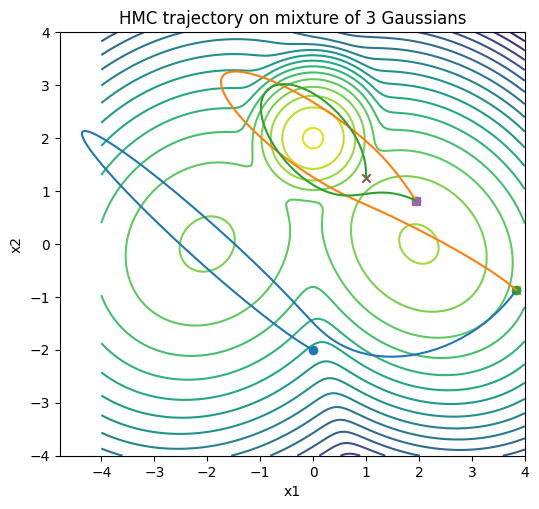

In [75]:
# Grid and contour plot
grid_lim = 4.0
xs = np.linspace(-grid_lim, grid_lim, 100)
ys = np.linspace(-grid_lim, grid_lim, 100)
X, Y = np.meshgrid(xs, ys)
Z = np.empty_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = log_prob_mixture([X[i, j], Y[i, j]])

fig, ax = plt.subplots(figsize=(6, 6))
cs = ax.contour(X, Y, Z, levels=20)
# ax.clabel(cs, inline=True, fontsize=8)
for path in paths:
    ax.plot(path[:, 0], path[:, 1])
    ax.scatter(path[0, 0], path[0, 1], marker="o")
    ax.scatter(path[-1, 0], path[-1, 1], marker="x")
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_title("HMC trajectory on mixture of 3 Gaussians")
ax.set_aspect("equal")
plt.show()

## Sample using HMC


In [76]:
np.random.seed(0)
dim = 2
n_samples = 100
initial_q = np.array([0.0, 0.0])
start = perf_counter()
samples_hmc, acceptance_rate_hmc = hmc_sample(
    log_prob_mixture,
    grad_log_prob_mixture,
    n_samples=n_samples,
    step_size=0.1,
    n_steps=20,
    dim=dim,
    initial_q=initial_q,
)
time_hmc = perf_counter() - start
print(f"HMC sampling took {time_hmc:.3f} seconds.")
print(f"HMC acceptance rate: {acceptance_rate_hmc:.3f}")

HMC sampling took 0.386 seconds.
HMC acceptance rate: 0.890


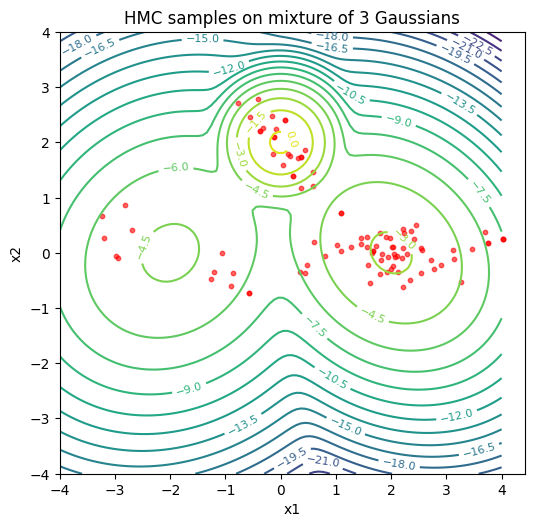

In [77]:
# Plot samples on top of contour plot
fig, ax = plt.subplots(figsize=(6, 6))
cs = ax.contour(X, Y, Z, levels=20)
ax.clabel(cs, inline=True, fontsize=8)
ax.scatter(samples_hmc[:, 0], samples_hmc[:, 1], color="red", s=10, alpha=0.6)
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_title("HMC samples on mixture of 3 Gaussians")
ax.set_aspect("equal")
plt.show()

In [78]:
def log_true_density(x):
    vals = [
        w * multivariate_normal.pdf(x, mean=m, cov=c)
        for w, m, c in zip(weights, means, covs)
    ]
    return np.log(np.sum(vals))


def kl_samples_vs_target(samples):
    samples = np.asarray(samples)

    kde = gaussian_kde(samples.T)
    log_p_hat = np.log(kde(samples.T))
    log_p_true = np.array([log_true_density(x) for x in samples])

    return np.mean(log_p_hat - log_p_true)


kl_hmc = kl_samples_vs_target(samples_hmc)
print("KL divergence (samples vs target):", kl_hmc)

KL divergence (samples vs target): 0.847718293521624


## Metropolis for comparison


In [79]:
import numpy as np


def metropolis_sample(log_prob, n_samples, proposal_scale, dim, initial_q):
    """
    Random-walk Metropolis sampler for baseline comparison.

    log_prob: function returning unnormalised log density
    n_samples: number of samples
    proposal_scale: standard deviation of Gaussian proposal
    dim: dimension of the state space
    initial_q: initial position, shape (dim,)

    Returns:
        samples of shape (n_samples, dim)
    """
    samples = np.zeros((n_samples, dim))
    accepted = 0
    q = np.asarray(initial_q, dtype=float).copy()

    for i in range(n_samples):
        # Gaussian random-walk proposal
        q_prop = q + proposal_scale * np.random.normal(size=dim)

        current_logp = log_prob(q)
        proposed_logp = log_prob(q_prop)

        log_accept_ratio = proposed_logp - current_logp

        if np.log(np.random.rand()) < log_accept_ratio:
            q = q_prop
            accepted += 1

        samples[i] = q

    return samples, accepted / n_samples

In [80]:
# Plot the full path of Metropolis samples
q0 = np.array([0.0, -2.0])
start = perf_counter()
samples_metropolis, acc_rate = metropolis_sample(
    log_prob=log_prob_mixture,
    n_samples=n_samples,
    proposal_scale=0.5,
    dim=2,
    initial_q=q0,
)
time_metropolis = perf_counter() - start

print(f"Metropolis sampling took {time_metropolis:.3f} seconds.")
print(f"Metropolis acceptance rate: {acc_rate:.3f}")

Metropolis sampling took 0.065 seconds.
Metropolis acceptance rate: 0.620


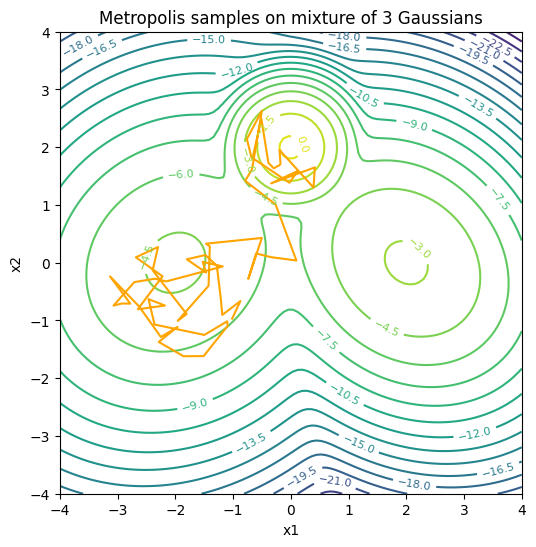

In [81]:
# Contour plot plus Metropolis path
fig, ax = plt.subplots(figsize=(6, 6))
cs = ax.contour(X, Y, Z, levels=20)
ax.clabel(cs, inline=True, fontsize=8)
ax.plot(samples_metropolis[:, 0], samples_metropolis[:, 1], color="orange")
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_title("Metropolis samples on mixture of 3 Gaussians")
ax.set_aspect("equal")
plt.show()

In [82]:
# KL divergence for Metropolis samples
kl_metropolis = kl_samples_vs_target(samples_metropolis)
print("KL divergence (samples vs target):", kl_metropolis)

KL divergence (samples vs target): 1.4412396378805594
